In [282]:
import segmentation_models
from segmentation_models import Unet
from segmentation_models import backbones 
#import get_preprocessing
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

In [263]:
from PIL import Image
from tqdm import tqdm_notebook
import os

In [264]:
import numpy as np
import matplotlib.pyplot as plt

In [306]:
import keras.backend as K
from keras.callbacks import TensorBoard

In [265]:
model = segmentation_models.Unet()

In [266]:
def read_images(directory='./train/'):
    images = {}
    masks = {}
    filelist = list(os.listdir(directory))
    for file in tqdm_notebook(filelist):
        image = Image.open(f'{directory}{file}')
        image = image.resize(size=(224,224))
        img_array = np.asarray(image)
        if "_mask" not in file:
            images[file[:-4]] = img_array
        else:
            masks[file[:-9]] = img_array 
    return images, masks

def prepare_dataset(images, masks):
    X_dict = images
    Y_dict = masks
    indices_with_masks = X_dict.keys()
    X = [X_dict[key] for key in indices_with_masks]
    Y = [Y_dict.get(key, 0) for key in indices_with_masks]
    indices_with_masks_list = list(indices_with_masks)
    x = np.array([np.transpose([x, x, x]) for x in X])
    y = np.array([np.transpose([y]) / 255 for y in Y])
    return x, y

In [267]:
images, masks = read_images()

In [268]:
train_x, train_y = prepare_dataset(images, masks)

37_105


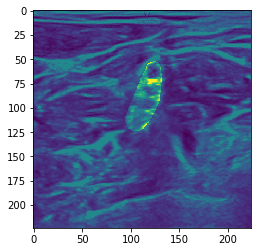

12_42


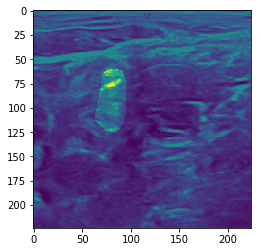

5_18


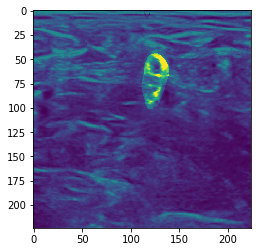

In [269]:
%matplotlib inline

for i, (x, y) in enumerate(zip(X[0:10], Y[0:10])):
    if np.max(y)>0:
        print(indices_with_masks_list[i])
        plt.imshow(x*(y / 255 + 0.9))
        plt.show()

In [372]:
preprocessing_fn = backbones.get_preprocessing('resnet34')
train_x = preprocessing_fn(train_x)

In [373]:
train_train_x, val_train_x, train_train_y, val_train_y = train_test_split(train_x, train_y, test_size=0.3)

In [382]:
def bce_dice_loss(input, target):
    smooth = 1.

    iflat = input
    tflat = target
    intersection = K.sum(iflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (K.sum(iflat) + K.sum(tflat) + smooth)) + K.binary_crossentropy(target, input)

In [379]:
test_input = K.placeholder(shape=(10, 10, 1))
test_target = K.placeholder(shape=(10, 10, 1))
test_loss = dice_loss(test_input, test_target)
K.get_session().run(test_loss, {
    test_input: np.ones((10, 10, 1)),
    test_target: np.ones((10, 10, 1))
})
np.random.rand(10, 10, 1).shape

(10, 10, 1)

In [383]:
# prepare model
model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
model.compile('Adam', bce_dice_loss, ['binary_accuracy'])

In [387]:
# train model
model.fit(
    train_train_x, train_train_y, 
    validation_data=(val_train_x, val_train_y), 
    callbacks=[TensorBoard(log_dir='./log', batch_size=32, update_freq='batch')],
    epochs=10
)

Train on 3944 samples, validate on 1691 samples
Epoch 1/10
3944/3944 [==============================] - 750s 190ms/step - loss: 0.5481 - binary_accuracy: 0.9912 - val_loss: 0.6466 - val_binary_accuracy: 0.9878
Epoch 2/10
3944/3944 [==============================] - 744s 189ms/step - loss: 0.5082 - binary_accuracy: 0.9917 - val_loss: 0.6545 - val_binary_accuracy: 0.9881
Epoch 3/10
3944/3944 [==============================] - 741s 188ms/step - loss: 0.5248 - binary_accuracy: 0.9915 - val_loss: 0.6965 - val_binary_accuracy: 0.9848
Epoch 4/10
3944/3944 [==============================] - 738s 187ms/step - loss: 0.4902 - binary_accuracy: 0.9919 - val_loss: 0.6395 - val_binary_accuracy: 0.9871
Epoch 5/10
3944/3944 [==============================] - 748s 190ms/step - loss: 0.4710 - binary_accuracy: 0.9921 - val_loss: 0.5956 - val_binary_accuracy: 0.9886
Epoch 6/10
3944/3944 [==============================] - 748s 190ms/step - loss: 0.4391 - binary_accuracy: 0.9927 - val_loss: 0.5807 - val_bina

In [365]:
np.sum(model.predict(x[i:i+1])[0].reshape(224, 224) == 1.0)

6971

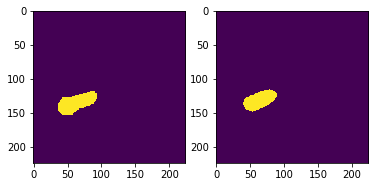

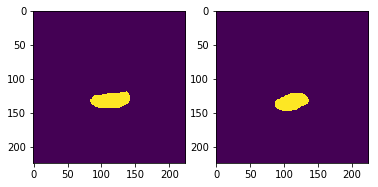

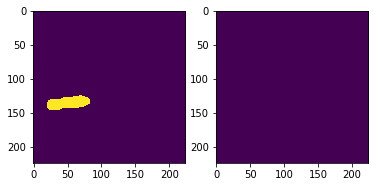

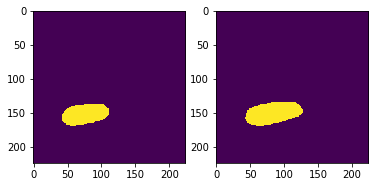

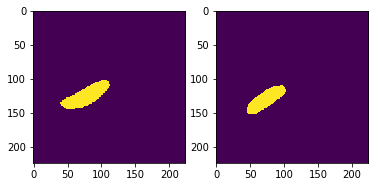

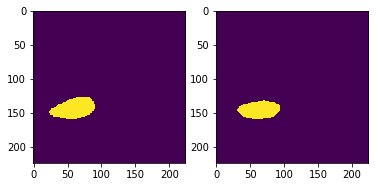

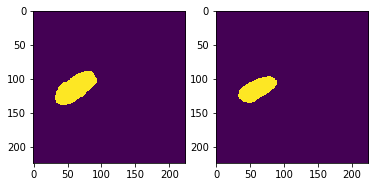

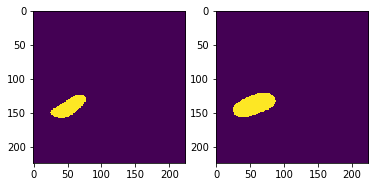

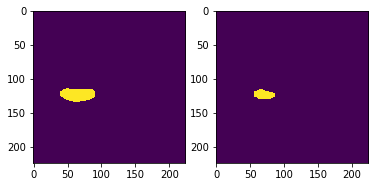

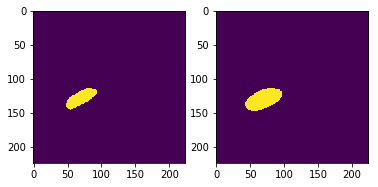

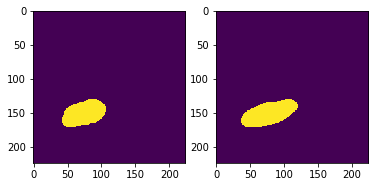

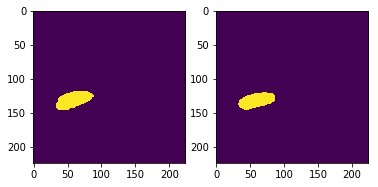

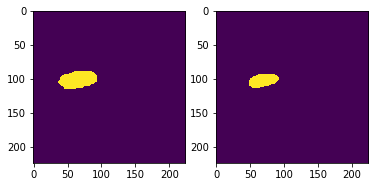

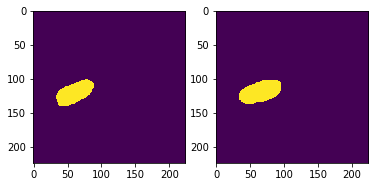

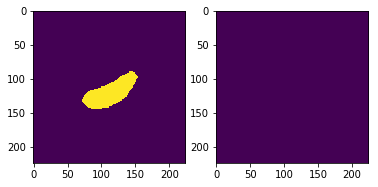

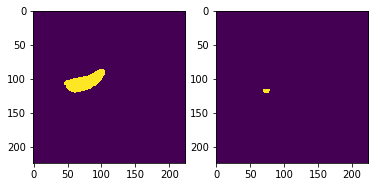

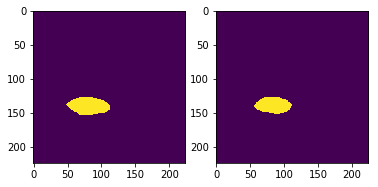

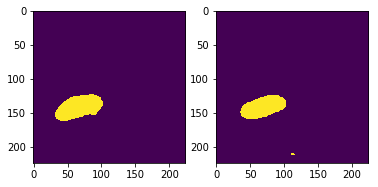

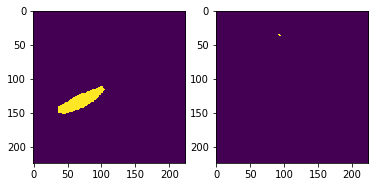

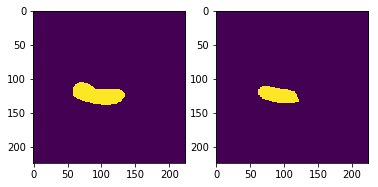

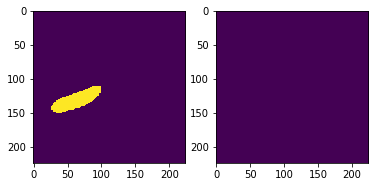

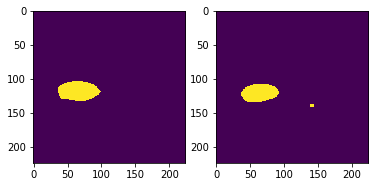

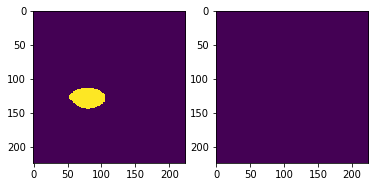

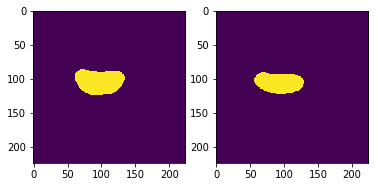

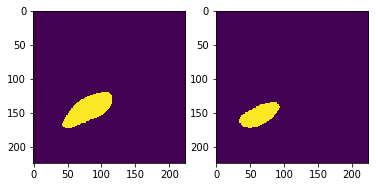

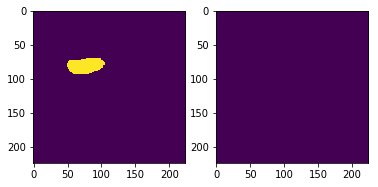

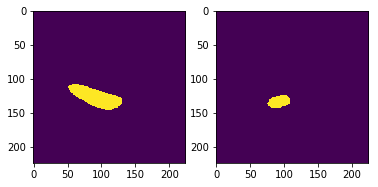

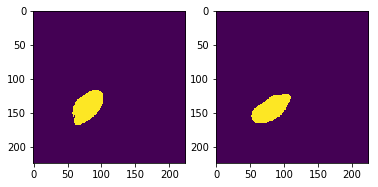

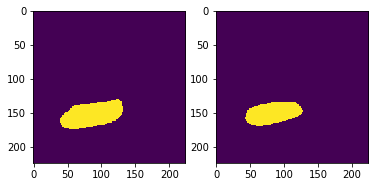

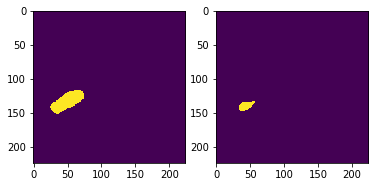

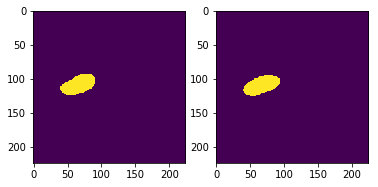

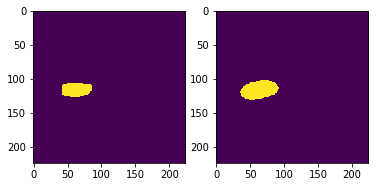

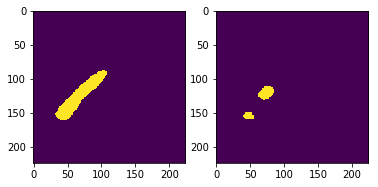

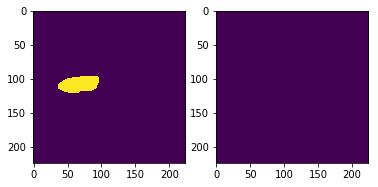

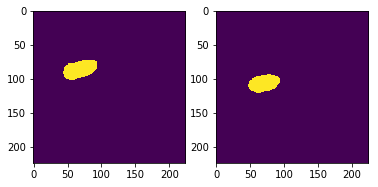

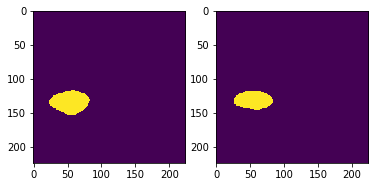

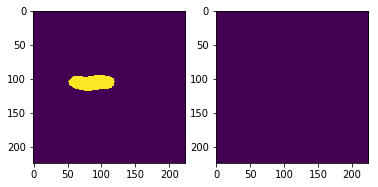

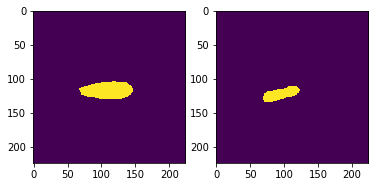

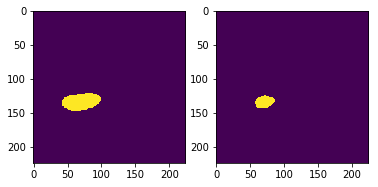

KeyboardInterrupt: 

In [388]:
x = val_train_x
y = val_train_y
for i in range(0,100):
    prediction = model.predict(x[i:i+1])[0].reshape(224, 224)
    mask = y[i].reshape(224, 224)
    image = x[i].transpose()[0].transpose()
    if np.max(mask) > 0:
        plt.subplot(121)
        plt.imshow(mask)
        plt.subplot(122)
        plt.imshow(prediction > 0.8)
        plt.show()

In [390]:
# train model on all data
model.fit(
    train_x, train_y, 
    callbacks=[TensorBoard(log_dir='./log', batch_size=32, update_freq='batch')],
    epochs=5
)

Epoch 1/5
5635/5635 [==============================] - 893s 159ms/step - loss: 0.4567 - binary_accuracy: 0.9924
Epoch 2/5
5635/5635 [==============================] - 901s 160ms/step - loss: 0.4478 - binary_accuracy: 0.9925
Epoch 3/5


KeyboardInterrupt: 

In [391]:
model.save_weights("full_weights.h5")
model.save("full.h5")

In [392]:
test_images, test_masks = read_images("./test/")

In [393]:
test_x, test_y = prepare_dataset(test_images, test_masks)

In [394]:
test_x = preprocessing_fn(test_x)

In [395]:
masks = model.predict(test_x)

In [396]:
shape_to_scale = np.asarray(Image.open(f'./test/148.tif')).transpose().shape
shape_to_scale

(580, 420)

In [397]:
def scale(image, interpolation=cv2.INTER_CUBIC):
    return cv2.resize(image, dsize=shape_to_scale, interpolation=interpolation)

INTER_NEAREST - a nearest-neighbor interpolation
INTER_LINEAR - a bilinear interpolation (used by default)
INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

In [398]:
masks[0].reshape(224, 224).transpose().shape

(224, 224)

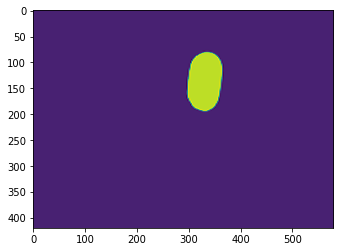

In [399]:
plt.imshow(scale(masks[0].reshape(224, 224).transpose(), cv2.INTER_CUBIC))
plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_NEAREST))
# plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_LINEAR))
# plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_AREA))
# plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_LANCZOS4))

(array([2.72768851e+08, 5.82440000e+04, 3.80870000e+04, 3.12500000e+04,
        2.81240000e+04, 2.84110000e+04, 3.07520000e+04, 3.75410000e+04,
        5.79110000e+04, 3.29023700e+06]),
 array([8.9295931e-08, 1.0000008e-01, 2.0000008e-01, 3.0000007e-01,
        4.0000007e-01, 5.0000006e-01, 6.0000002e-01, 7.0000005e-01,
        8.0000001e-01, 9.0000004e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

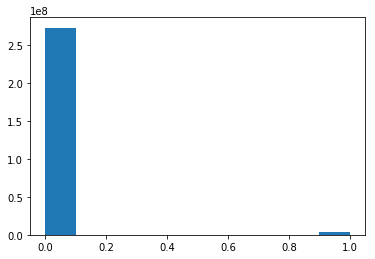

In [419]:
plt.hist(masks.reshape(-1))

In [409]:
scaled_masks = [scale(mask.reshape(224, 224).transpose()) for mask in tqdm_notebook(masks)]

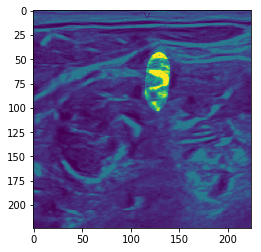

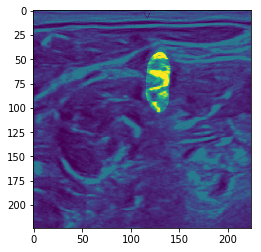

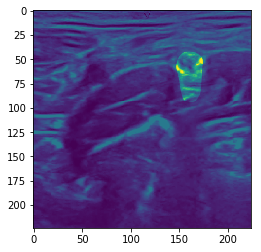

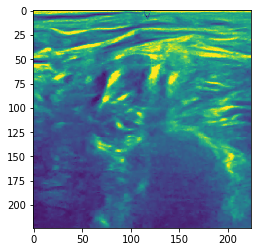

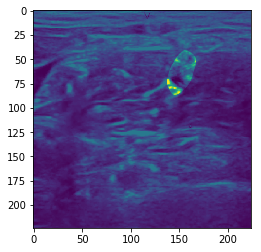

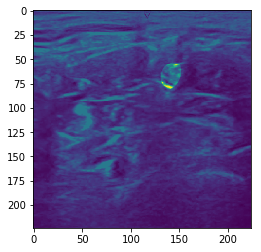

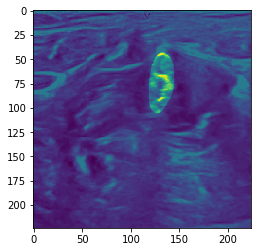

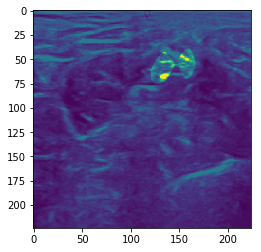

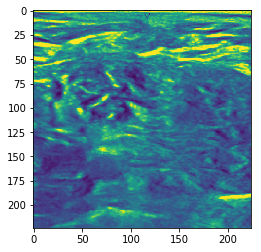

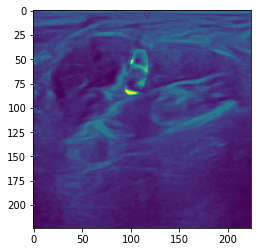

In [401]:
for x, mask in zip(test_x[0:10], masks[0:10]):
    image = x.transpose()[0]
    plt.imshow(image * (mask.reshape(224, 224).transpose() + 0.7))
    plt.show()

In [410]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [411]:
scaled_masks = [rle_encoding(mask > 0.1) for mask in tqdm_notebook(scaled_masks)]

In [412]:
" ".join([str(i) for i in scaled_masks[0]])

'124475 9 124871 41 125289 43 125696 60 126114 63 126532 66 126944 77 127364 78 127781 82 128199 86 128618 88 129035 92 129455 93 129874 95 130292 98 130711 100 131130 101 131549 102 131968 104 132388 105 132807 106 133226 107 133645 109 134065 110 134484 111 134904 111 135323 112 135743 112 136163 113 136582 114 137002 115 137421 116 137841 116 138261 116 138681 116 139101 116 139521 116 139941 116 140361 116 140781 116 141201 116 141621 115 142041 114 142461 114 142881 114 143301 113 143721 112 144141 112 144562 110 144982 109 145403 108 145823 107 146243 106 146664 104 147085 102 147505 101 147926 100 148347 96 148767 95 149188 93 149610 88 150030 88 150452 80 150873 77 151293 76 151716 62 152137 60 152560 48 152984 35 153405 31'

In [413]:
images = list(test_images.keys())
string_masks = [" ".join([str(i) for i in mask]) for mask in tqdm_notebook(scaled_masks)]
string_masks = [mask or np.nan for mask in string_masks]

In [414]:
submission = pd.DataFrame()
submission["img"] = images
submission["pixels"] = string_masks
submission = submission.set_index("img")

In [415]:
submission.to_csv("our_submission.csv")